Training Accuracy (with custom threshold): 0.4375
Validation (Test) Accuracy (with custom threshold): 0.3550
Cross-Validation Mean Accuracy: 0.3200

Confusion Matrix (with custom threshold):
[[47 19  0]
 [48 24  0]
 [39 23  0]]


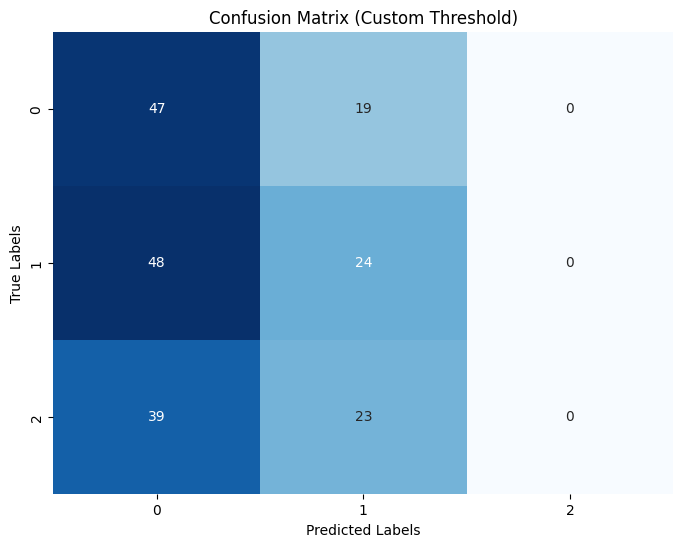

In [39]:
import numpy as np
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')  # Ignore warnings

# Load the dataset
df = pd.read_csv("defects_data.csv")

# Drop irrelevant columns
df = df.drop(columns=['defect_id', 'product_id'])

# Encode categorical target variable (assuming 'severity' is categorical)
label_encoder = LabelEncoder()
df['severity'] = label_encoder.fit_transform(df['severity'])

# Separate features and target
X = df.drop(columns=['severity'])
y = df['severity']

# Identify categorical and numerical features
categorical_features = ['defect_type', 'defect_date', 'defect_location', 'inspection_method']
numerical_features = ['repair_cost']

# Preprocessing: One-hot encoding for categorical, scaling for numerical
column_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaler', StandardScaler(), numerical_features)
])

# Transform the features
X_transformed = column_transformer.fit_transform(X)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)


# Apply Logistic Regression model
model = LogisticRegression(C=0.15, max_iter=2000, class_weight='balanced')
model.fit(X_train, y_train)

# Get predicted probabilities instead of direct predictions
y_train_prob = model.predict_proba(X_train)[:, 1]  # Probabilities for the positive class
y_test_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Set a custom threshold (e.g., 0.5 is the default, but we can adjust it)
threshold = 0.35  # You can experiment with this value
y_train_pred_new = (y_train_prob > threshold).astype(int)
y_test_pred_new = (y_test_prob > threshold).astype(int)

# Calculate accuracy on the training and test set using the new threshold
train_accuracy_new = accuracy_score(y_train, y_train_pred_new)
test_accuracy_new = accuracy_score(y_test, y_test_pred_new)

# Cross-validation (optional but included)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_transformed, y, cv=cv, scoring='accuracy')

# Print Validation Results
print(f"Training Accuracy (with custom threshold): {train_accuracy_new:.4f}")
print(f"Validation (Test) Accuracy (with custom threshold): {test_accuracy_new:.4f}")
print(f"Cross-Validation Mean Accuracy: {cv_scores.mean():.4f}")

# Optionally, print precision, recall, F1 score, confusion matrix, and classification report
print("\nConfusion Matrix (with custom threshold):")
print(confusion_matrix(y_test, y_test_pred_new))

# Visualize the Confusion Matrix using a Heatmap
conf_matrix_new = confusion_matrix(y_test, y_test_pred_new)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_new, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix (Custom Threshold)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()